In [40]:
from __future__ import annotations
from PIL import Image
import numpy as np
from typing import Tuple

from gradientlab.img_utils.img_loader import ImageLoader
class ImageTextify:
    """
    Textify 64x64 images using:
      - Adaptive palette quantization (default K=64)
      - 2x2 tiles -> 4 palette indices (24 bits) packed into two 12-bit units
      - Base-4096 Unicode glyph alphabet (default starts at U+4E00)
      - Optional RLE post-pass over fixed-width records for fewer tokens

    Public API (unchanged):
        encode(img: Image.Image) -> str
        decode(s: str) -> Image.Image
    """

    def __init__(
        self,
        palette_size: int = 64,
        tile: int = 2,
        glyph_base: int = 0x4E00,          # Base-4096 alphabet start (CJK Unified Ideographs)
        dither: bool = False,
        force_size: Tuple[int, int] = (64, 64),
        # RLE options
        rle: bool = True,
        rle_marker: str = "\u3400",        # outside the base alphabet; reserved marker
        rle_min_run_override: int | None = None,  # set to force a custom threshold
    ):
        assert 2 <= palette_size <= 256
        assert tile in (1, 2)
        self.K = int(palette_size)
        self.tile = int(tile)
        self.base = int(glyph_base)
        self.dither = dither
        self.force_size = force_size

        self.rle = bool(rle)
        assert len(rle_marker) == 1
        self.rle_marker = rle_marker
        self.rle_min_run_override = rle_min_run_override

        # Precompute lookups for 0..4095 <-> Unicode glyphs
        self._enc_table = np.array([chr(self.base + i) for i in range(4096)], dtype=object)
        self._dec_table = {chr(self.base + i): i for i in range(4096)}

    # -------------------------
    # Public API
    # -------------------------
    def encode(self, img: Image.Image) -> str:
        """
        Encode a PIL Image -> compact Unicode string with optional RLE.
        """
        w, h = self.force_size
        im = img.convert("RGB").resize((w, h), Image.BICUBIC)

        # Palette quantization
        method = Image.FASTOCTREE
        dith = Image.FLOYDSTEINBERG if self.dither else Image.NONE
        pimg = im.quantize(colors=self.K, method=method, dither=dith)
        pal = np.array(pimg.getpalette()[: self.K * 3], dtype=np.uint8).reshape(self.K, 3)  # (K,3)
        idx = np.asarray(pimg, dtype=np.uint8)  # (h,w) in [0..K-1]

        # Pack palette (K entries * 24 bits => 2 base4096 symbols per color)
        pal_units = self._pack_palette(pal)  # (2K,) uint16 in [0..4095]
        pal_str = self._units_to_str(pal_units)

        # Pack indices by tiles -> base4096 units
        units = self._pack_indices(idx)

        # Decide record width for RLE
        recw = self._choose_record_width(self.tile, self.K)
        use_rle = self.rle and (recw in (1, 2))

        if use_rle:
            body_str = self._rle_units_to_str(units, recw)
            header = f"ITF2;{w};{h};{self.K};{self.tile};1;{recw};"
        else:
            body_str = self._units_to_str(units)
            # still emit ITF2 with rle=0 for uniformity
            header = f"ITF2;{w};{h};{self.K};{self.tile};0;0;"

        # Concatenate: header + palette + "|" + body
        return header + pal_str + "|" + body_str

    def decode(self, s: str) -> Image.Image:
        """
        Decode a textified string (ITF1 or ITF2) -> reconstructed PIL RGB Image.
        """
        header, remainder = self._split_header(s)
        magic = header[0]

        if magic == "ITF1":
            _, w, h, K, tile = header
            rle_flag, recw = 0, 0
        elif magic == "ITF2":
            _, w, h, K, tile, rle_flag, recw = header
        else:
            raise ValueError("Invalid magic.")

        K = int(K); tile = int(tile)
        w = int(w); h = int(h)
        rle_flag = int(rle_flag)
        recw = int(recw)

        pal_str, body_str = remainder.split("|", 1)
        pal_units = self._str_to_units(pal_str)

        # Rebuild palette
        pal = self._unpack_palette(pal_units, K)  # (K,3) uint8

        # Rebuild indices
        if magic == "ITF1":
            # Legacy: no RLE
            body_units = self._str_to_units(body_str)
        else:
            if rle_flag == 1:
                # recw may be 0 in header if encoder chose to disable; recompute if needed
                if recw not in (1, 2):
                    recw = self._choose_record_width(tile, K)
                    if recw not in (1, 2):
                        raise ValueError("RLE flagged but record width unsupported.")
                body_units = self._str_rle_to_units(body_str, recw)
            else:
                body_units = self._str_to_units(body_str)

        idx = self._unpack_indices(body_units, (h, w), K, tile)

        # Turn back into RGB via the palette
        pal_img = Image.new("P", (w, h))
        flatpal = pal.reshape(-1).tolist()
        flatpal += [0] * (256 * 3 - len(flatpal))
        pal_img.putpalette(flatpal)
        pal_img.putdata(idx.reshape(-1).tolist())
        return pal_img.convert("RGB")

    # -------------------------
    # Internals (palette)
    # -------------------------
    def _pack_palette(self, pal: np.ndarray) -> np.ndarray:
        pal = pal.astype(np.uint32)  # (K,3)
        rgb24 = (pal[:,0] << 16) | (pal[:,1] << 8) | pal[:,2]  # (K,)
        hi = (rgb24 >> 12) & 0xFFF
        lo = rgb24 & 0xFFF
        out = np.empty((pal.shape[0] * 2,), dtype=np.uint16)
        out[0::2] = hi.astype(np.uint16)
        out[1::2] = lo.astype(np.uint16)
        return out

    def _unpack_palette(self, units: np.ndarray, K: int) -> np.ndarray:
        assert units.size == 2 * K, "Palette units length mismatch."
        hi = units[0::2].astype(np.uint32)
        lo = units[1::2].astype(np.uint32)
        rgb24 = (hi << 12) | lo
        R = ((rgb24 >> 16) & 0xFF).astype(np.uint8)
        G = ((rgb24 >> 8) & 0xFF).astype(np.uint8)
        B = (rgb24 & 0xFF).astype(np.uint8)
        return np.stack([R, G, B], axis=1)

    # -------------------------
    # Internals (indices pack/unpack)
    # -------------------------
    def _pack_indices(self, idx: np.ndarray) -> np.ndarray:
        H, W = idx.shape
        if self.tile == 2:
            assert H % 2 == 0 and W % 2 == 0, "H,W must be divisible by 2."
            tiles = idx.reshape(H//2, 2, W//2, 2)
            i0 = tiles[:,0,:,0].astype(np.uint32)
            i1 = tiles[:,0,:,1].astype(np.uint32)
            i2 = tiles[:,1,:,0].astype(np.uint32)
            i3 = tiles[:,1,:,1].astype(np.uint32)
            if self.K <= 64:
                val = (i0 << 18) | (i1 << 12) | (i2 << 6) | i3
                hi = (val >> 12) & 0xFFF
                lo = val & 0xFFF
                units = np.empty((val.size * 2,), dtype=np.uint16)
                units[0::2] = hi.reshape(-1).astype(np.uint16)
                units[1::2] = lo.reshape(-1).astype(np.uint16)
                return units
            else:
                # Rare path: fall back to 8 units per tile (each index split hi/lo)
                i = np.stack([i0, i1, i2, i3], axis=-1).reshape(-1, 4)
                units = []
                for col in range(4):
                    v = i[:, col]
                    hi = (v >> 12) & 0xFFF
                    lo = v & 0xFFF
                    units.append(hi.astype(np.uint16))
                    units.append(lo.astype(np.uint16))
                return np.stack(units, axis=1).reshape(-1)

        else:  # tile == 1
            flat = idx.reshape(-1).astype(np.uint32)
            if self.K <= 64:
                if flat.size % 2 == 1:
                    flat = np.pad(flat, (0,1), mode="constant")
                a = flat[0::2]
                b2 = flat[1::2]
                units = ((a << 6) | b2) & 0xFFF
                return units.astype(np.uint16)
            else:
                hi = (flat >> 12) & 0xFFF
                lo = flat & 0xFFF
                out = np.empty((flat.size * 2,), dtype=np.uint16)
                out[0::2] = hi.astype(np.uint16)
                out[1::2] = lo.astype(np.uint16)
                return out

    def _unpack_indices(self, units: np.ndarray, shape: Tuple[int,int], K: int, tile: int) -> np.ndarray:
        H, W = shape
        if tile == 2:
            if K <= 64:
                assert units.size == (H//2) * (W//2) * 2, "Body length mismatch."
                hi = units[0::2].astype(np.uint32)
                lo = units[1::2].astype(np.uint32)
                val = (hi << 12) | lo
                i0 = (val >> 18) & 0x3F
                i1 = (val >> 12) & 0x3F
                i2 = (val >> 6) & 0x3F
                i3 = val & 0x3F
                i0 = i0.reshape(H//2, W//2)
                i1 = i1.reshape(H//2, W//2)
                i2 = i2.reshape(H//2, W//2)
                i3 = i3.reshape(H//2, W//2)
                out = np.empty((H, W), dtype=np.uint8)
                out[0::2, 0::2] = i0
                out[0::2, 1::2] = i1
                out[1::2, 0::2] = i2
                out[1::2, 1::2] = i3
                return out
            else:
                num_tiles = (H//2) * (W//2)
                expected = num_tiles * 8
                assert units.size == expected, "Body length mismatch (tile=2,K>64)."
                units = units.reshape(num_tiles, 8).astype(np.uint32)
                out = np.empty((num_tiles, 4), dtype=np.uint32)
                for col in range(4):
                    hi = units[:, 2*col]
                    lo = units[:, 2*col + 1]
                    out[:, col] = (hi << 12) | lo
                i0 = out[:,0].reshape(H//2, W//2)
                i1 = out[:,1].reshape(H//2, W//2)
                i2 = out[:,2].reshape(H//2, W//2)
                i3 = out[:,3].reshape(H//2, W//2)
                o8 = np.empty((H, W), dtype=np.uint8)
                o8[0::2, 0::2] = i0
                o8[0::2, 1::2] = i1
                o8[1::2, 0::2] = i2
                o8[1::2, 1::2] = i3
                return o8

        else:  # tile == 1
            if K <= 64:
                n_pix = H * W
                need = (n_pix + 1) // 2
                assert units.size == need, "Body length mismatch (tile=1,K<=64)."
                u = units.astype(np.uint32)
                a = (u >> 6) & 0x3F
                b2 = u & 0x3F
                flat = np.empty((need * 2,), dtype=np.uint8)
                flat[0::2] = a
                flat[1::2] = b2
                flat = flat[:n_pix]
                return flat.reshape(H, W)
            else:
                n_pix = H * W
                assert units.size == 2 * n_pix, "Body length mismatch (tile=1,K>64)."
                hi = units[0::2].astype(np.uint32)
                lo = units[1::2].astype(np.uint32)
                v = ((hi << 12) | lo).astype(np.uint8)
                return v.reshape(H, W)

    # -------------------------
    # RLE helpers
    # -------------------------
    def _choose_record_width(self, tile: int, K: int) -> int:
        """
        Decide record width (in glyphs) for RLE.
        - tile=2 & K<=64  -> 2 glyphs per record (one 2x2 tile)
        - tile=1 & K<=64  -> 1 glyph per record
        - otherwise       -> 0 (disable)
        """
        if K <= 64 and tile == 2:
            return 2
        if K <= 64 and tile == 1:
            return 1
        return 0

    def _rle_threshold(self, recw: int) -> int:
        """
        Minimum run length that provides net savings:
          cost(raw * c) = c * recw
          cost(rle)     = 2 (marker+count) + recw
          benefit when  2 + recw < c * recw  -> c > (2+recw)/recw
        So:
          recw=2 -> c>=3 ; recw=1 -> c>=4
        Allow override via rle_min_run_override.
        """
        if self.rle_min_run_override is not None:
            return max(2, int(self.rle_min_run_override))
        return 3 if recw == 2 else 4

    def _rle_units_to_str(self, units: np.ndarray, recw: int) -> str:
        """
        Convert units -> glyph string with RLE on fixed-size records.
        Record is recw glyphs (recw in {1,2}).
        Encoding:
           raw record: [recw glyphs]
           run (len=c >= threshold): [MARKER][COUNT][record]
           COUNT is a single base-4096 glyph, value=c (2..4095)
        """
        assert recw in (1, 2)
        assert units.size % recw == 0
        enc = self._enc_table  # uint16 -> glyph

        recs = units.reshape(-1, recw).astype(np.uint32)
        # pack row to scalar key for fast run discovery
        if recw == 2:
            keys = (recs[:, 0] << 12) | recs[:, 1]
        else:
            keys = recs[:, 0]

        # find run starts
        starts = np.r_[0, np.nonzero(keys[1:] != keys[:-1])[0] + 1]
        lengths = np.diff(np.r_[starts, len(keys)])

        marker = self.rle_marker
        thr = self._rle_threshold(recw)
        out_parts = []
        for st, ln in zip(starts, lengths):
            rec_units = recs[st]
            if ln >= thr and ln <= 4095:
                # compressed form
                out_parts.append(marker)
                out_parts.append(enc[ln])  # COUNT glyph
                for u in rec_units:
                    out_parts.append(enc[u])
            else:
                # raw copies
                g0 = enc[rec_units[0]]
                if recw == 2:
                    g1 = enc[rec_units[1]]
                    out_parts.extend((g0 + g1) * ln)
                else:
                    out_parts.extend(g0 * ln)

        return "".join(out_parts)

    def _str_rle_to_units(self, s: str, recw: int) -> np.ndarray:
        """
        Parse glyph string with RLE back to units.
        """
        assert recw in (1, 2)
        dec = self._dec_table
        marker = self.rle_marker
        units = []

        i = 0
        N = len(s)
        while i < N:
            ch = s[i]
            if ch == marker:
                if i + 1 + recw >= N:
                    raise ValueError("Truncated RLE sequence.")
                count = dec.get(s[i + 1], None)
                if count is None or count < 2:
                    raise ValueError("Invalid RLE count.")
                if recw == 1:
                    u0 = dec.get(s[i + 2], None)
                    if u0 is None:
                        raise ValueError("Invalid RLE unit.")
                    units.extend((u0,))
                    # replicate (count-1) more
                    units.extend([u0] * (count - 1))
                    i += 2 + 1
                else:
                    u0 = dec.get(s[i + 2], None)
                    u1 = dec.get(s[i + 3], None)
                    if (u0 is None) or (u1 is None):
                        raise ValueError("Invalid RLE units.")
                    units.extend((u0, u1))
                    # replicate pair (count-1) times
                    units.extend([u0, u1] * (count - 1))
                    i += 2 + 2
            else:
                # raw record
                u0 = dec.get(ch, None)
                if u0 is None:
                    raise ValueError("Unexpected glyph outside alphabet.")
                units.append(u0)
                i += 1
                if recw == 2:
                    if i >= N:
                        raise ValueError("Truncated raw record.")
                    u1 = dec.get(s[i], None)
                    if u1 is None:
                        raise ValueError("Unexpected glyph outside alphabet.")
                    units.append(u1)
                    i += 1

        return np.array(units, dtype=np.uint16)

    # -------------------------
    # 12-bit units <-> unicode glyphs
    # -------------------------
    def _units_to_str(self, units: np.ndarray) -> str:
        glyphs = self._enc_table[units.astype(np.uint16)]
        return "".join(glyphs.tolist())

    def _str_to_units(self, s: str) -> np.ndarray:
        try:
            return np.fromiter((self._dec_table[ch] for ch in s), dtype=np.uint16, count=len(s))
        except KeyError:
            # Helpful error if someone feeds an RLE'd string here by mistake
            raise ValueError("Encountered non-alphabet glyph; did you mean to use RLE decoding?")

    # -------------------------
    # Header parsing (ITF1 + ITF2)
    # -------------------------
    def _split_header(self, s: str):
        """
        Header formats:
          ITF1;w;h;K;tile;             (5 semicolons)
          ITF2;w;h;K;tile;rle;recw;    (7 semicolons)
        Returns (tuple_of_fields, remainder_after_header)
        """
        parts = []
        acc = []
        semis = 0
        required = 5  # assume ITF1 until we read magic

        for i, ch in enumerate(s):
            if ch == ';':
                parts.append("".join(acc))
                acc = []
                semis += 1
                # After first semicolon, we know magic and thus required semicolons
                if semis == 1:
                    if parts[0] == "ITF2":
                        required = 7
                    elif parts[0] == "ITF1":
                        required = 5
                    else:
                        raise ValueError("Invalid magic in header.")
                if semis == required:
                    header_end = i + 1
                    break
            else:
                acc.append(ch)
        else:
            raise ValueError("Header not found or incomplete.")

        remainder = s[header_end:]
        return tuple(parts), remainder

In [54]:
textify = ImageTextify(palette_size=32, tile=2)
imgl = ImageLoader()

In [ ]:
img = imgl.to_pil("https://datasets-server.huggingface.co/cached-assets/visual-layer/imagenet-1k-vl-enriched/--/ac6afcdeb3be31c5ff6a7ff579874b3d372b7074/--/default/train/203/image/image.jpg?Expires=1761994512&Signature=W5jT~RdG-EH1Sb8njItj4zo3ZhCm2b6UFJgpnlPnKr-o~mSDDc4tJHZk-8h9k2v0LzLbRyVIOKdTs8tju~t-upTNJl5xvVR4Xam5pUBGLagOXvve50JstlKVeY9w~5xNxH6g4uH4B7dOo~bW7buBuLHB7WSwLfH~-gT3bO4oRnbiba5NkBR1ayRT-VuUd4Bq1yLqf1mJzStqXQHyoSYDMBCxcs9XmbqRSlHjEC0E76QpVL1uhgECGD1~KleDGTucahngQ2q~riTNB-Oz9KAPZbZlocZ1Y~79bDNatXZibLwrV2AgoW8hix3P7RxmakL96G2BTDv9Al2Sl4n22ZMaGA__&Key-Pair-Id=K3EI6M078Z3AC3")
img

In [67]:
imgcode = textify.encode(img)
len(imgcode)

2123

In [68]:
imgcode

'ITF2;64;64;32;2;1;2;句娨坈婟唖奖堩官嚇啝嚸尪喨儩噇吵勃唥僂圓嗈佋媌哊冤匑媋喣娬冦姫寃婙女噇岀婋峁咆唷喇吷啷呆嚈呇呕嘸啦噇咆呆噇塇器吹呦嘨呵坆商嘸啧唨|仃伃仃仃仄仃仂仃亂仃仃仃亂亀亂亂亂亃㐀七仃仃伄仄吝伂亂乁乃仃仄伃亂仃亂亁乃仃㐀七仃仃仂仂乃乃仃仃乁乃仃仃仃仂乃亁仃仃乂仃亃亂亃亂仄九亄丝仃伂仃亄乗乄亂丂亂亂仃乑仃仃僋介仃僋仃仃仃仃仁付亃叄仃乂仃亂仃亃仃仃仄仃亂亓乘勀各一企俚咁一仃企乂乁伄乁仃伄仃亁叝一亄亄仙仁丂亁亝亂啂仃乄仃亂仃亂亂乂乁亃仃仃仃僋凋仄仂亄亁众仁一亓一勞丂吁亃乃仃仃仃仃乕乂员亙叀啓喘卂喜勀勂井亄十仃仃亗亓丙勔一亂亂仂乃呃仃仏仄仃仃仃仃仂仃亄仂仁亁亂仃亂仃亂仏亃㐀七仃仃仄仁亂伂亃亁仁乃仂仃乃企乂伂亀伓丙丙単勓勂卙亂亁乁仁仃乁亂乄厕乖伄仃仄伄丂呙仃亂亂偀仂亀亀喚丗咀亄亄叜吔丝喂亂亂亂亂仃乃伄仂伂吝亄亄乘乄動勘亃呄僃仃乂伂吘勘咁各丙唓勓呓卂十十卓乁单伂伕厁咄乁乁介仃仄仁亃介仂僃丂亂亀亙動取咜乓乃仃乁仁乂仁亂仃亂亃伃乃仄仃伂仃剃仃亄亁企仁厕乘吙伄亂十亁亁优乄叙勂井单乘亙勀一且唟厇哛吘乘伄伄亂亂伂亙介亃僃仃仃仃亂乁咁乁乂乖乃乃仁仁仃仃仃仃仁仃乃仃仃仃仃乁仃俄乃乁仄乁嗓咓吕勓乁亃亂亂卂呙单卙丝丗呙啙啗亝唀一丁丆乓专众受吘啀丂一啝倂亄亄乃乁乁俛久俇乖乁匁哖乁哅乁乁仃乃仃仃仁亓五唆嗀丗一丗匔卛喇勓厓匓勓吓呁丂亂呁亂乂呙亙亂亂呙呂亀亀一丂一乖一一变勀勀厇三倉偂偝亁乁乇俔俁匁哛久俁俛历嗀品嗇厁協乚佛乁侁亀乂包丛喗优专呝吕伕卂呂勜一伜卟一一勄亂伙亂亙亙亂亙呂丙亂呂呓一乁丂变丂呞吀匔卜偉唀偉偉亄偁俁乍咇乖咇咞俅匛侜咀嗛包厚佇乁乖哛俁傊哂呓呙呙啓呂呂仄乐乁乄伄企伀伄丙咖呂嗀亂亂乙乂呁呁亂亂一专丄千吂优倀一吗啗募一嗀唀倉偉偝偈名名允仄喞一叞吞喀匜万嗜佟俆匔喞化乄卂伄亂亂亂各乄伀伐倄伄伝乄啀伄一伄丄咙企勓亁匙吗亂呂亂些募侟咔哛丄咄啂亂啀亂一偈东喀偉偉丂偂乁仚乁侗丗众吚匔喓丞匟嗟丕唓企乄乄叝亂啂伄亀亗一倈倈倈倈亂倂一丝倈丈丗倈一倈伄一仂伄亄亂侀一厀唓侖乄乘九丂丂啝伝偀丂唀乞偉亘丘伄乚品匘乁众优供南亘吞唀勘勂咇一俀丂丂亂吝亀啀一丝丈丈倈倈倈倈倗丝亂啂亗亂丈亘倈丈丂倀吘亚勓专专區亞吓吂亞勖嗓伄叁亂亂勘会伂咄伃伃乁仔乁乄乘咇争吝乄亂亄亘俀伇丄咘优吘吗优一亝啝一丈一倈一倀一丝丂啝吂啝啝亂啝吗啝丈啀倗丈亄啄乀哕丂丙亚企仃冃唘丆亂亂众仕丁參仄僃匚俁乚単会伄亂予啀俇俇倀喜一丞一

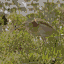

In [69]:
textify.decode(imgcode)